# Applied Deep Learning Assignment Task 1
`Name: Gangula Karthik`<br>
`Admin_no: 223715Y`

---

_**Develop and compare deep learning and transfer learning models for early brain tumor detection and classification to optimize treatment selection and improve patient outcomes.**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

Brain tumors are abnormal growths within or around the brain that can be malignant or benign, requiring accurate and early diagnosis for effective treatment. Distinguishing brain tumors from other cystic or tumor-like growths in MRI scans remains a significant challenge in medical imaging. Advanced deep learning techniques offer the potential to enhance early detection and diagnosis, reducing misclassification and improving patient outcomes. Based on their location and origin, brain tumors can be categorized into types such as Gliomas, which originate in the brain or spinal cord; Meningiomas, arising from the protective membranes (meninges) surrounding the brain and spinal cord; and Pituitary Tumors, which develop in the pituitary gland. Developing deep learning-based models to differentiate between these tumor types and similar-appearing cysts in MRI scans is crucial for guiding timely and appropriate treatment strategies.

---

### Setup

Import all the Python libraries we will need

---

In [25]:
# !pip install tensorflow-addons

In [26]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm import tqdm
import phik

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.17.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

ModuleNotFoundError: No module named 'keras.src.engine'

### Loading the datasets

Parsing the folders and putting them in a dataframe.

---

In [4]:
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

In [5]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory): 
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for img_file in os.listdir(label_path):  
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [6]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

'Test DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

### Data Understanding

Analysing the data in depth in order to understand the data and how to apply different transformations. 

---

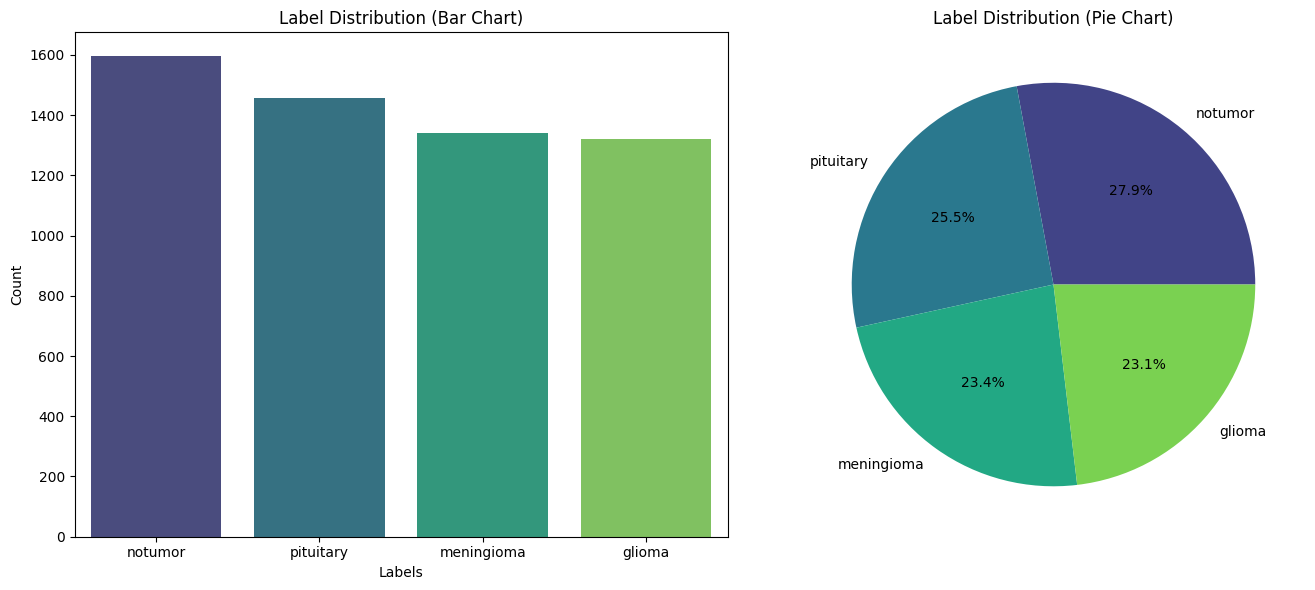

In [7]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [8]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None 

train_df["width"], train_df["height"] = zip(*train_df["file_path"].apply(get_image_size))

train_df["aspect_ratio"] = train_df["width"] / train_df["height"]

train_df[["width", "height", "aspect_ratio"]].describe()

width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


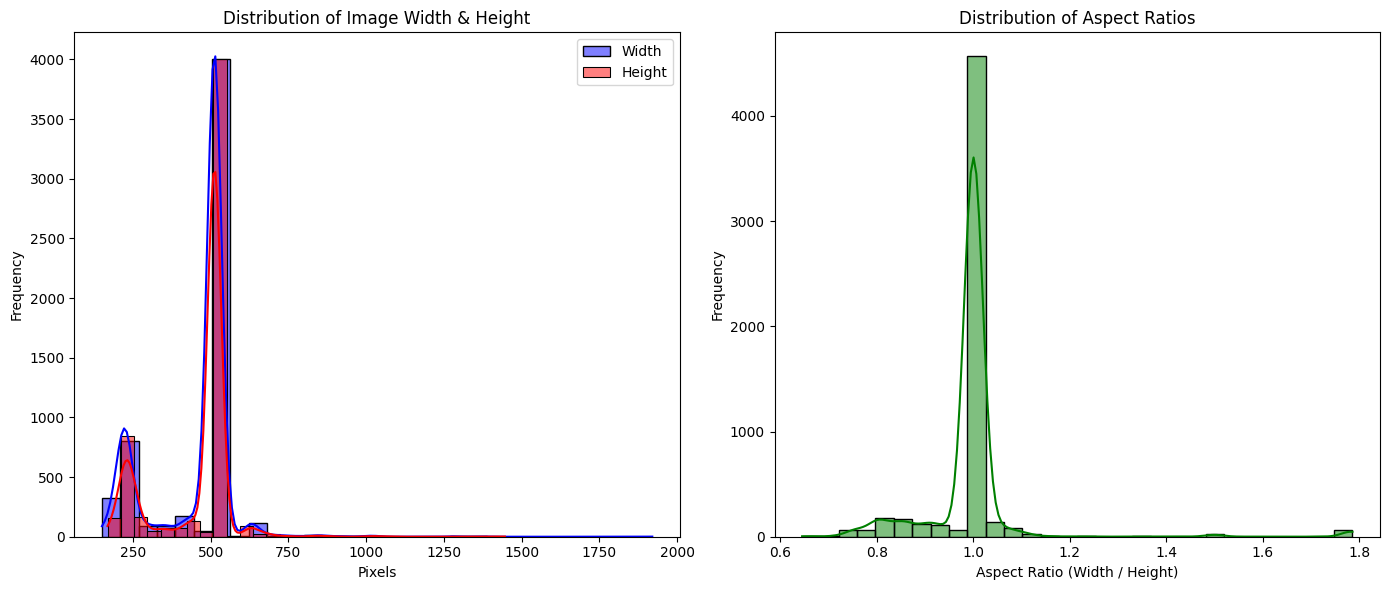

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

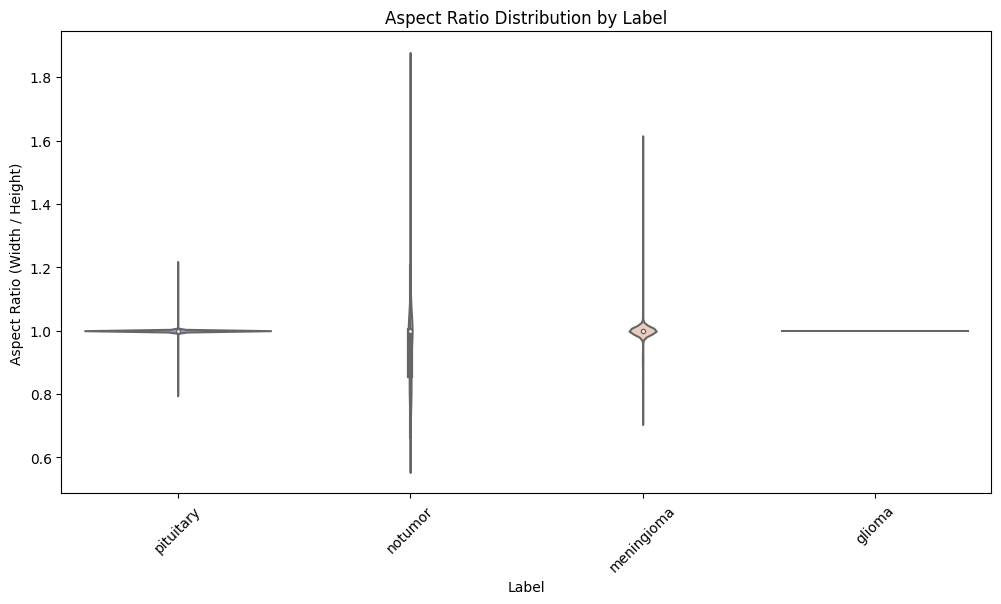

In [10]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

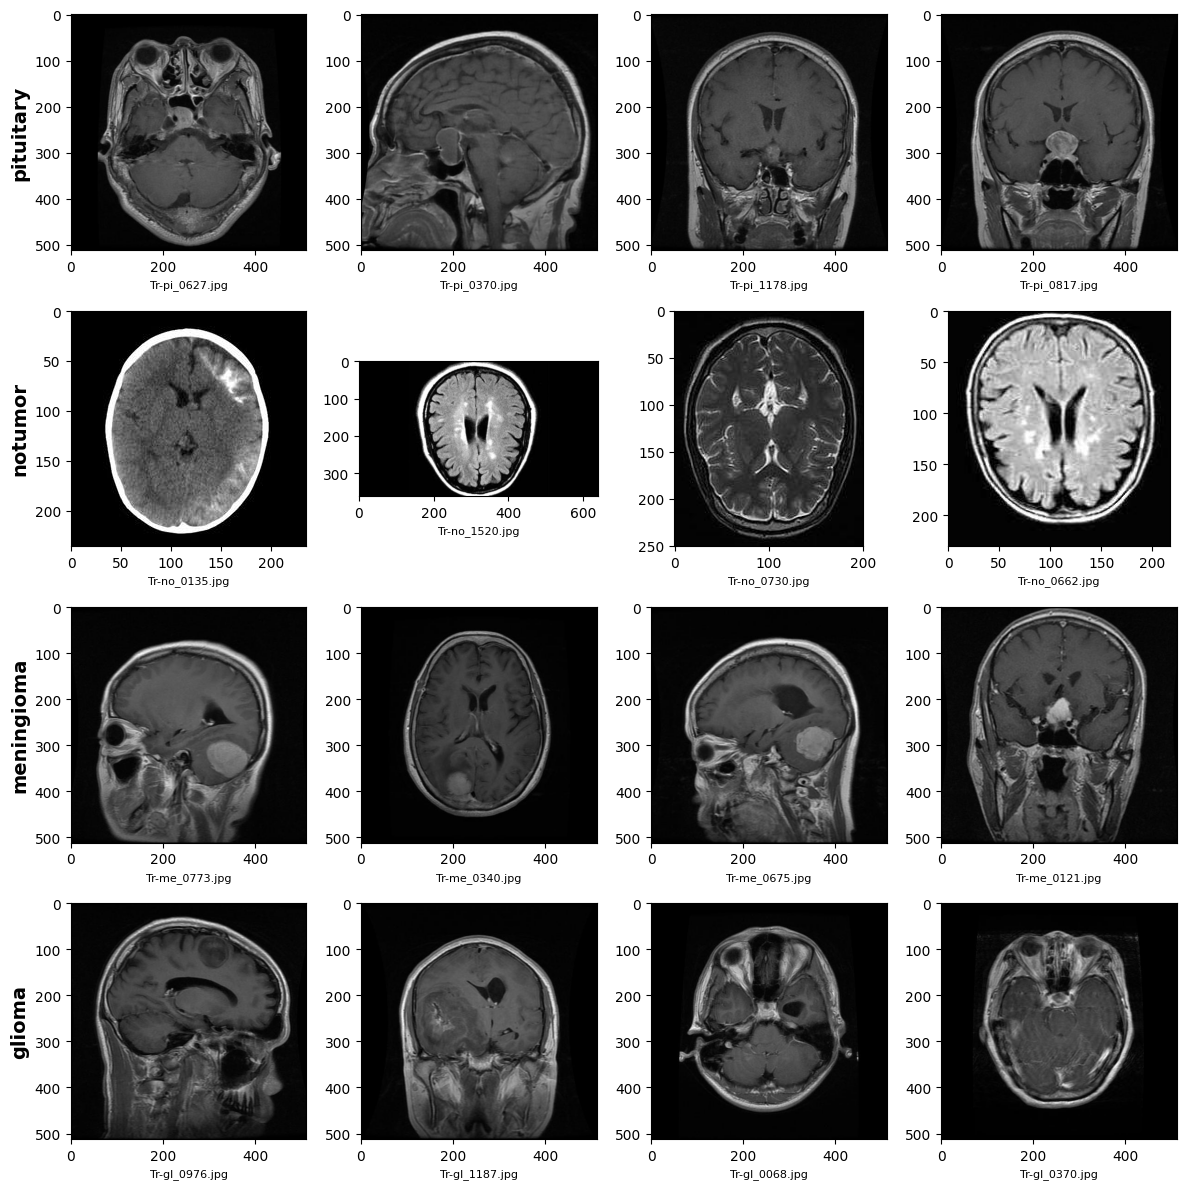

In [11]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)
    
    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = axes[row, col]
        ax.imshow(img)
        
        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold") 
        
        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

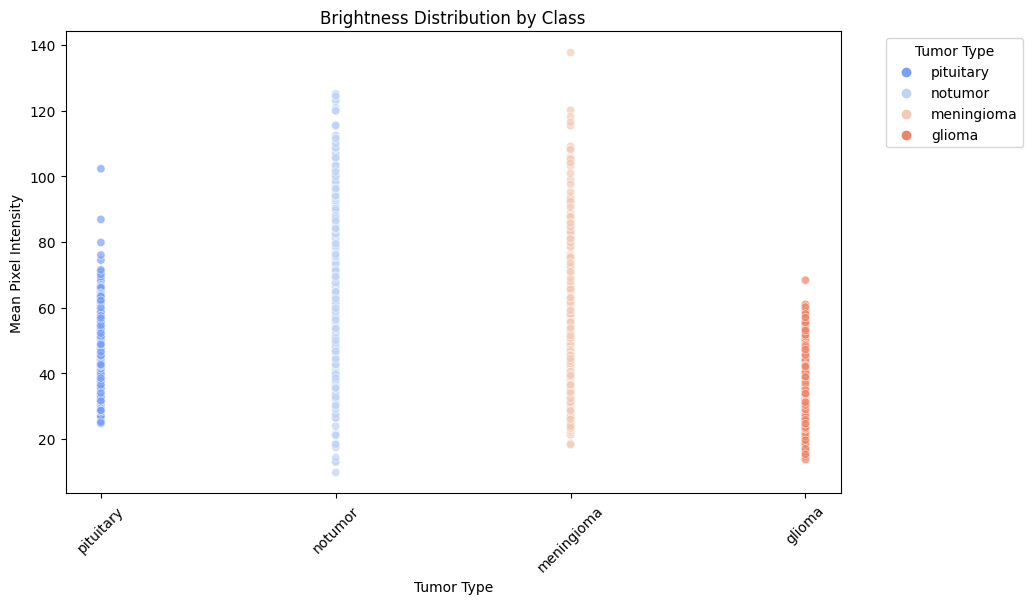

In [12]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["label"], y=train_df["brightness"], alpha=0.7, hue=train_df["label"], palette="coolwarm")
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

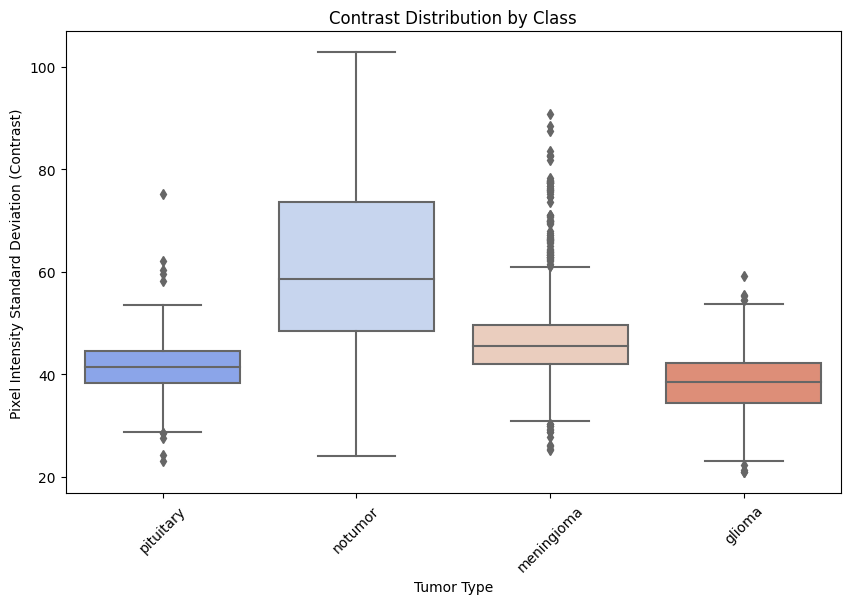

In [13]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

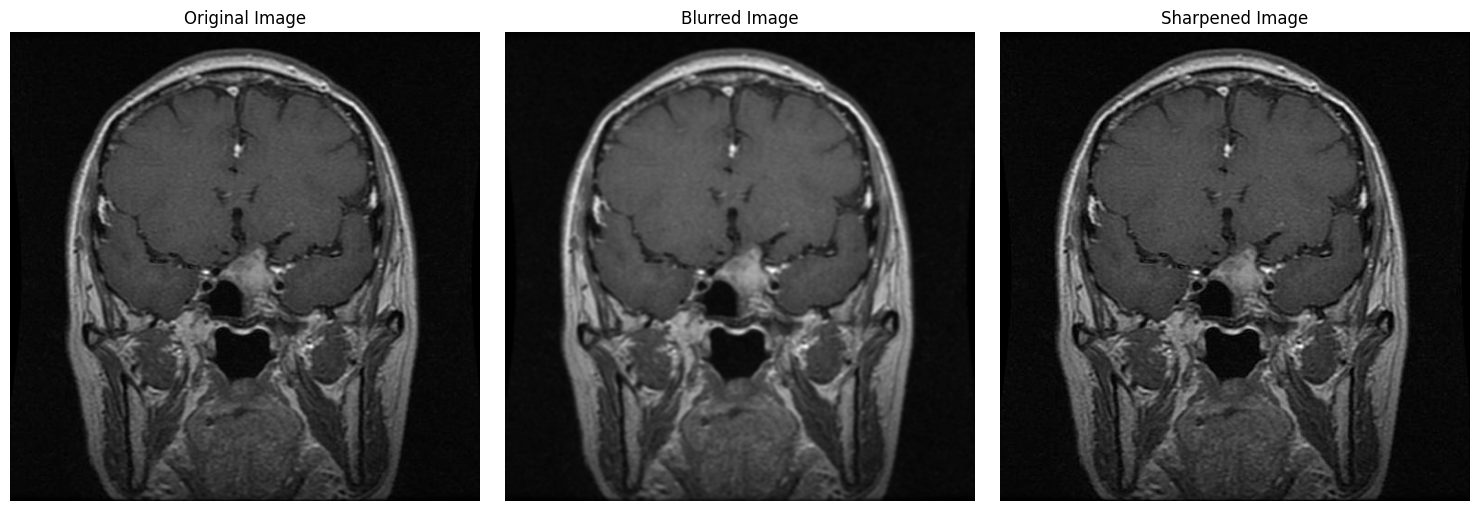

In [14]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

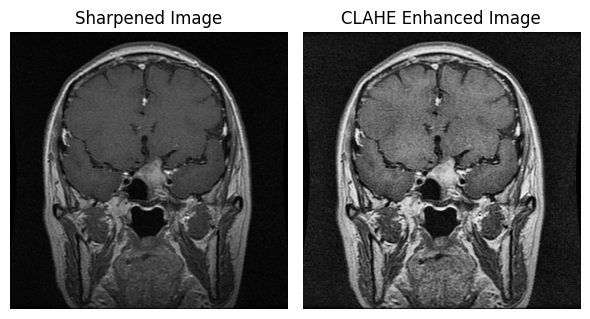

In [15]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

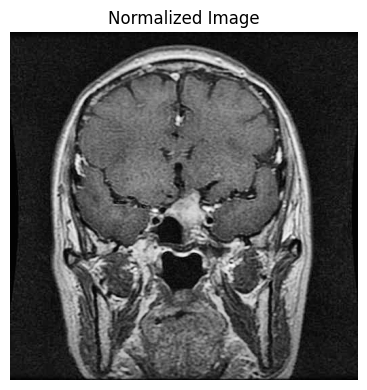

In [16]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

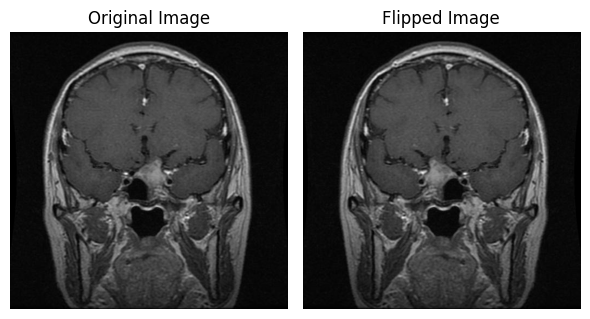

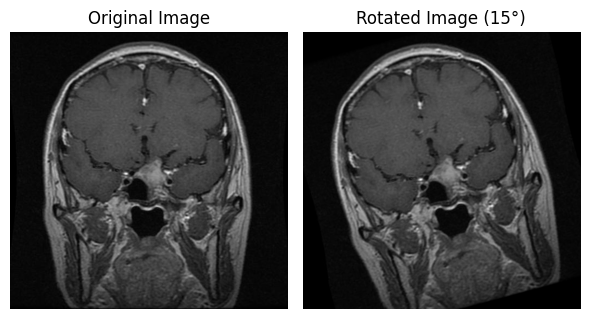

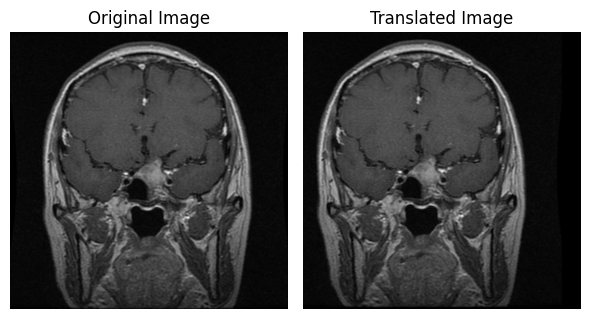

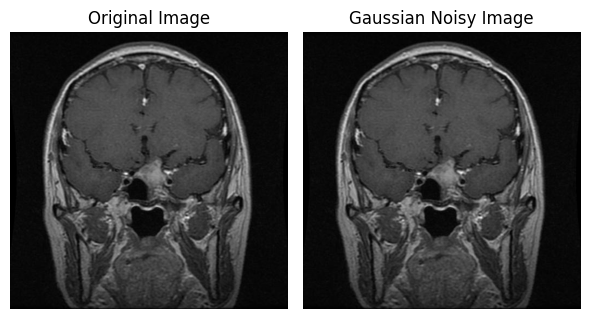

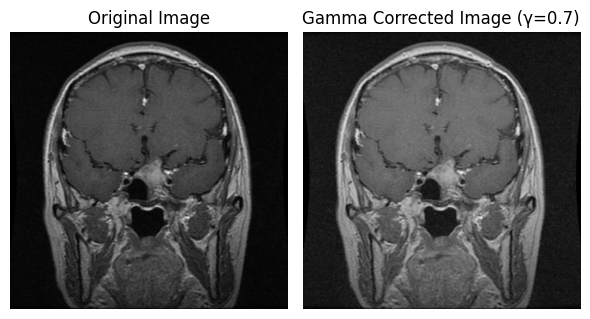

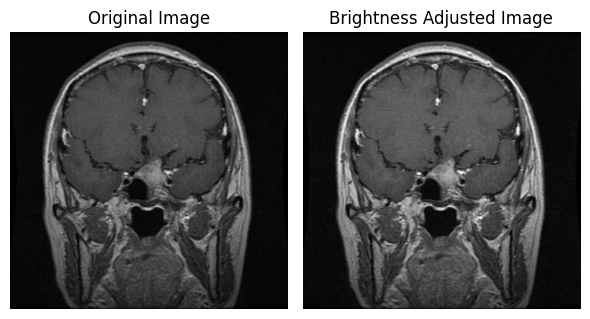

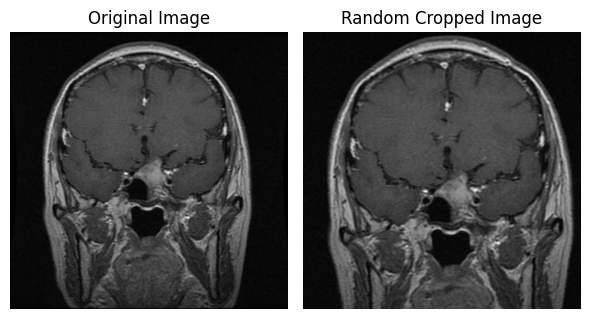

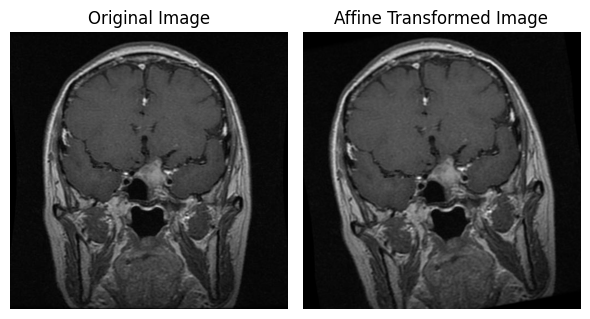

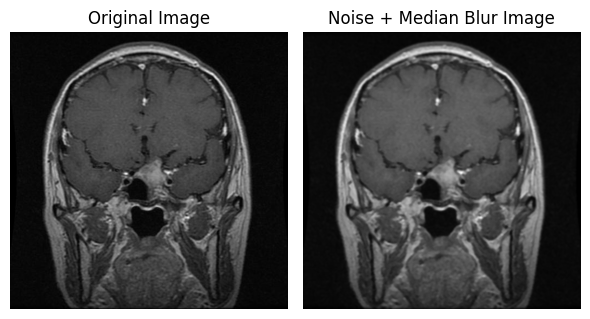

In [17]:
# Load MRI image (replace with your image path)
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_single_transformation(original, transformed, title):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### 1️⃣ Horizontal Flip ###
flipped = cv2.flip(img, 1)  # 1 means horizontal flip
visualize_single_transformation(img, flipped, "Flipped Image")

### 2️⃣ Rotation (±15 degrees) ###
angle = 15  # 15 degrees rotation
(h, w) = img.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
visualize_single_transformation(img, rotated, "Rotated Image (15°)")

### 3️⃣ Translation (10% random shift) ###
tx, ty = np.random.randint(-int(w*0.1), int(w*0.1)), np.random.randint(-int(h*0.1), int(h*0.1))
M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
translated = cv2.warpAffine(img, M_translation, (w, h))
visualize_single_transformation(img, translated, "Translated Image")

### 4️⃣ Gaussian Noise (σ=0.03) ###
noise = np.random.normal(0, 0.05, img.shape).astype(np.uint8)
gaussian_noisy = cv2.add(img, noise)
visualize_single_transformation(img, gaussian_noisy, "Gaussian Noisy Image")

### 5️⃣ Gamma Correction (γ=0.7) ###
gamma_corrected = np.array(255 * (img / 255) ** 0.7, dtype='uint8')
visualize_single_transformation(img, gamma_corrected, "Gamma Corrected Image (γ=0.7)")

### 6️⃣ Brightness Adjustment ###
brightness_factor = 40  # You can modify this to increase/decrease brightness
bright_img = cv2.add(img, brightness_factor)  # Increase brightness by adding constant value
visualize_single_transformation(img, bright_img, "Brightness Adjusted Image")

### 7️⃣ Random Cropping (85-95% ROI) ###
crop_size = np.random.randint(int(0.85 * img.shape[0]), int(0.95 * img.shape[0]))
crop_x = np.random.randint(0, img.shape[1] - crop_size)
crop_y = np.random.randint(0, img.shape[0] - crop_size)
cropped = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
visualize_single_transformation(img, cropped, "Random Cropped Image")

### 8️⃣ Affine Stack (Rotation + Shift + Scale) ###
scale_factor = np.random.uniform(0.9, 1.1)
M_affine = cv2.getRotationMatrix2D(center, 10, scale_factor)
affine_transformed = cv2.warpAffine(img, M_affine, (w, h))
visualize_single_transformation(img, affine_transformed, "Affine Transformed Image")

### 9️⃣ Noise + Blur (Gaussian Noise + Median 3x3) ###
blurred = cv2.GaussianBlur(gaussian_noisy, (5, 5), 0)
median_blurred = cv2.medianBlur(blurred, 3)
visualize_single_transformation(img, median_blurred, "Noise + Median Blur Image")

### Data Preparation

---

In [18]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

# Function to preprocess the image
def preprocess_image(image_path):
    image_path = image_path.numpy().decode('utf-8')  # Decode tensor to string path
    img = cv2.imread(image_path)
    
    # Resize image while maintaining the aspect ratio (resize to the smaller dimension)
    img_resized = resize_with_aspect_ratio(img, target_height=224, target_width=224)
    
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(sharpened)
    normalized_img = (img_clahe - np.mean(img_clahe)) / np.std(img_clahe)
    normalized_img = normalized_img / 255.0
    
    return normalized_img

# Resize function that maintains aspect ratio and resizes to fixed dimensions
def resize_with_aspect_ratio(img, target_height, target_width):
    # Get the original image dimensions
    original_height, original_width = img.shape[:2]
    
    # Compute the aspect ratio
    aspect_ratio = original_width / original_height
    
    # Compute new dimensions keeping the aspect ratio intact
    if aspect_ratio > 1:
        # Wider than tall, resize based on width
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        # Taller than wide, resize based on height
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    # Resize the image to the new dimensions
    img_resized = cv2.resize(img, (new_width, new_height))
    
    # Resize to fixed target dimensions (224x224)
    img_resized_fixed = cv2.resize(img_resized, (target_width, target_height))
    
    return img_resized_fixed

# Function to process the dataset with tqdm progress bar
def load_and_preprocess_from_df(df):
    file_paths = df['file_path'].values
    labels = df['label'].values
    
    # Create a dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    
    # Custom mapping function with tqdm progress bar
    def map_with_progress(file_path, label):
        # Use tf.py_function to apply the preprocessing function
        processed_image = tf.py_function(preprocess_image, [file_path], tf.float32)
        return processed_image, label
    
    # Apply the mapping function with progress bar
    dataset = dataset.map(lambda x, y: map_with_progress(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply map and batch functions for efficient processing
    dataset = dataset.apply(tf.data.experimental.map_and_batch(
        map_func=lambda x, y: (x, y),
        batch_size=32
    ))
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Assuming you have 'train_df' defined somewhere in your code with 'file_path' and 'label' columns
train_dataset = load_and_preprocess_from_df(train_df)

# Shuffle, batch, and prefetch the dataset
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

In [19]:
# Display the dataset
for image_batch, label_batch in train_dataset.take(1):
    print(image_batch.shape, label_batch.shape)

(32, 224, 224) (32,)


### Image Augmentation

---

In [20]:
def add_gaussian_noise(image):
    """ Adds Gaussian noise (σ=0.03) to an image. """
    image = image.numpy()  # Convert tensor to NumPy
    noise = np.random.normal(0, 0.05, image.shape).astype(np.float32)  # Generate noise
    noisy_image = image + noise  # Add noise
    return np.clip(noisy_image, 0, 1)  # Keep values in range [0,1]

def random_crop(image):
    """ Random cropping (85-95% ROI) """
    img_shape = tf.shape(image)
    crop_size = tf.random.uniform([], int(0.85 * tf.cast(img_shape[0], tf.float32)), 
                                  int(0.95 * tf.cast(img_shape[0], tf.float32)), dtype=tf.int32)
    return tf.image.random_crop(image, size=[crop_size, crop_size, 1])  # Crop image

def apply_augmentations(image, label):
    """ Apply augmentations with a 40% probability """
    
    prob = tf.random.uniform([], 0, 1)  # Generate a random number

    def augment(image):
        # **1️⃣ Horizontal Flip**
        image = tf.image.random_flip_left_right(image)

        # **2️⃣ Rotation (±15 degrees)**
        angle = tf.random.uniform([], minval=-15, maxval=15, dtype=tf.float32)
        image = tfa.image.rotate(image, angle * np.pi / 180)

        # **3️⃣ Random Translation (10% shift)**
        tx = tf.random.uniform([], minval=-0.1, maxval=0.1) * tf.cast(tf.shape(image)[1], tf.float32)
        ty = tf.random.uniform([], minval=-0.1, maxval=0.1) * tf.cast(tf.shape(image)[0], tf.float32)
        image = tfa.image.translate(image, [tx, ty])

        # **4️⃣ Gaussian Noise**
        image = tf.py_function(func=add_gaussian_noise, inp=[image], Tout=tf.float32)

        # **5️⃣ Gamma Correction (γ=0.7)**
        image = tf.image.adjust_gamma(image, gamma=0.7)

        # **6️⃣ Brightness Adjustment**
        image = tf.image.random_brightness(image, max_delta=0.2)

        # **7️⃣ Random Cropping (85-95%)**
        image = random_crop(image)

        # **8️⃣ Affine Transform (Rotation + Scaling)**
        scale_factor = tf.random.uniform([], 0.9, 1.1)  # Scale between 90% to 110%
        image = tfa.image.transform(image, [scale_factor, 0, 0, 0, scale_factor, 0, 0, 0])

        # **9️⃣ Noise + Blur (Gaussian Noise + Median 3x3)**
        image = tfa.image.gaussian_filter2d(image, filter_shape=(5, 5), sigma=1.0)
        
        return image

    # Apply augmentations only 40% of the time
    image = tf.cond(prob < 0.4, lambda: augment(image), lambda: image)

    return image, label

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.map(apply_augmentations, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(AUTOTUNE)

NameError: in user code:

    File "<ipython-input-20-29e4070b1d4c>", line 26, in augment  *
        image = tfa.image.rotate(image, angle * np.pi / 180)

    NameError: name 'tfa' is not defined


### Simple CNN Model

---

### Model Building, Selection, and Evaluation

---

In [100]:
# import modules
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [101]:
# Define different Pipelines for Numeric vs. Categorical
# Categorical preprocessing
categorical_pipeline = Pipeline(steps=[
    ('categorical_imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot_encoder', OneHotEncoder(handle_unknown="ignore"))
])

# Numeric preprocessing
numeric_pipeline = Pipeline(steps=[
    ('numeric_imputer', SimpleImputer(strategy="median")),
    ('scaler', MinMaxScaler())
])

# Combine categorical and numerical preprocessing into single preprocessor
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(exclude="number").columns
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical_preprocessor", categorical_pipeline, categorical_features),
        ("numeric_preprocessor", numeric_pipeline, numeric_features),
    ]
)


# Define a single Pipeline with all of the steps
models = [LogisticRegression(), KNeighborsClassifier(), RandomForestClassifier(), XGBClassifier()]
cv_accuracys = []
for model in models:
    steps = [
        ('preprocessor', preprocessor),
        # Try different models and select the one with the best cross_val_score
        ('regressor', model)
    ]
    pipeline = Pipeline(steps)
    cv_accuracy = cross_val_score(pipeline, X_train, y_train, cv=4, scoring="accuracy")
    cv_accuracy = pd.Series(cv_accuracy)
    print(f"{model} Cross Validation Test Accuracy Distribution\n")
    display(cv_accuracy.describe())
    # Get the mean_test_score from the cross_val_score
    cv_accuracys.append(cv_accuracy.mean())

LogisticRegression() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.713333
std      0.007201
min      0.706667
25%      0.709167
50%      0.711667
75%      0.715833
max      0.723333
dtype: float64

KNeighborsClassifier() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.685000
std      0.022690
min      0.653333
25%      0.678333
50%      0.690000
75%      0.696667
max      0.706667
dtype: float64

RandomForestClassifier() Cross Validation Test Accuracy Distribution



count    4.000000
mean     0.721667
std      0.012323
min      0.706667
25%      0.714167
50%      0.723333
75%      0.730833
max      0.733333
dtype: float64

[13:44:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:42] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:44:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=Non

count    4.000000
mean     0.716667
std      0.016330
min      0.696667
25%      0.711667
50%      0.716667
75%      0.721667
max      0.736667
dtype: float64

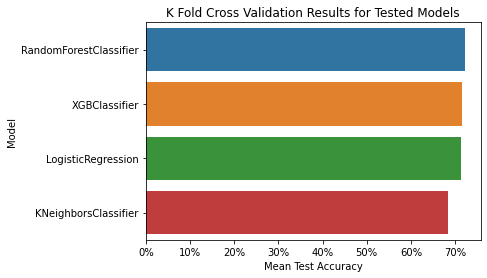

model  cross_validation_accuracy
2  RandomForestClassifier                   0.721667
3           XGBClassifier                   0.716667
0      LogisticRegression                   0.713333
1    KNeighborsClassifier                   0.685000

Maximum cross validation Accuracy (0.72) acheived with RandomForestClassifier model


In [102]:
cv_results = pd.DataFrame({
    "model": [str(model).split("(")[0] for model in models],
    "cross_validation_accuracy": cv_accuracys
}).sort_values(by="cross_validation_accuracy", ascending=False)
sns.barplot(data=cv_results, y="model", x="cross_validation_accuracy")
ax = plt.gca()
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.title("K Fold Cross Validation Results for Tested Models")
plt.xlabel("Mean Test Accuracy")
plt.ylabel("Model")
plt.show()
display(cv_results)
best_model = cv_results.loc[cv_results['cross_validation_accuracy'].idxmax()]['model']
print(f"Maximum cross validation Accuracy ({max(cv_results['cross_validation_accuracy']):,.2f}) acheived with {best_model} model")

**Explicitly say which model you expect to perform the best and why.**

Cross validation lets us estimate how well our models will perform on the future data (like our Test set), thus we will proceed with the model that yields the lowest cross validation Accuracy.

The `model` yielded the lowest cross validation Accuracy, so will use it as our final model and proceed to tuning.

In [103]:
# Inspect parameters that we can tune with `model`.get_params().keys()

In [104]:
# Reset Pipeline with best model
steps = [
        ('preprocessor', preprocessor),
        ('regressor', RandomForestClassifier())
    ]
pipeline = Pipeline(steps)

# Set up the parameter distributions to search over
param_distributions = {}

# Tune the hyperparameters for the best model
cv = RandomizedSearchCV(pipeline
                  , cv = 4
                  , scoring="accuracy"
                  , param_distributions=param_distributions
                  , random_state=42)

cv.fit(X_train, y_train)

cv_results = pd.DataFrame(cv.cv_results_)

print(f"CV Results")
display(cv_results.sort_values(by="mean_test_score").head(5))
print(f"Best Hyperparameters\n{cv.best_params_}")

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CV Results


mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
0       0.163347      0.001888         0.012396        0.000367     {}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0           0.716667               0.73           0.733333           0.726667   

   mean_test_score  std_test_score  rank_test_score  
0         0.726667        0.006236                1

Best Hyperparameters
{}


After experimenting with feature extraction, feature selection, and other processing techniques, you should choose the model that yielded the lowest CV Accuracy on the training data.

If the tuned model had the lowest CV Accuracy, then make sure you use the hyperparameters you found when you do your final validation on the test set.

This will be the final model that you deploy for future predictions.

### Baseline Model Comparison

In [105]:
# Compare the best model with the baseline model
print(f"Best Model CV Average Accuracy Score = {cv.best_score_:,.2f}")
print(f"Baseline Model Test Accuracy (using mode as the predicted value) = {baseline_accuracy:,.2f}")
print(f"Improvement over the baseline = {cv.best_score_ - baseline_accuracy:,.2f}, or {100 * (cv.best_score_ - baseline_accuracy) / baseline_accuracy:,.2f}%")

Best Model CV Average Accuracy Score = 0.73
Baseline Model Test Accuracy (using mode as the predicted value) = 0.59
Improvement over the baseline = 0.14, or 23.86%


In [106]:
# Final evaluation of the model on the test set
X_test = test_data.drop(columns=[target])
y_test = test_data[target].copy()
y_pred = cv.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy = {test_accuracy:,.2f}")

Test Accuracy = 0.70


**Confusion Matrix**

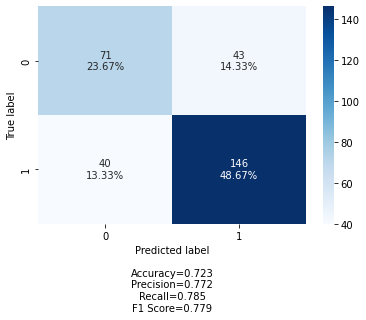

In [107]:
from utils.classification import plot_confusion_matrix

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cf_matrix)

### Conclusion


---

Comment on your findings here and provide a summary. 

Include: 
1. The model you would choose to deploy (if any) 
2. A table of results of the different models you tested
3. Model performance across different subsets (ie, geographies, customer offering, etc.)
  * Should we not deploy for certain subsets/groups?
4. Steps on how to maintain and update the model in production in a way stakeholders can understand

### Appendix


---

Add any exploratory or supporting work that doesn't fit into the story of your report. Add any citations you used here as well.

In [108]:
from sklearn.feature_selection import SelectKBest, f_classif

# Checkout how to integrate feature selection methods inside of your Pipeline here: https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html

# Get the max number of features that model can use
processing_and_fe_steps = [
    ('preprocessor', preprocessor),
    ('interactions', PolynomialFeatures())
]
processing_and_fe_pipeline = Pipeline(processing_and_fe_steps)
n_features = processing_and_fe_pipeline.fit_transform(X_train).shape[1]

k_list = np.linspace(10, n_features, dtype="int")
test_accuracys = []
train_accuracys = []
for k in k_list:
    steps = [
        ('preprocessor', preprocessor),
        ('interactions', PolynomialFeatures()),
        ('dim_red', SelectKBest(score_func=f_classif, k=k)),
        ('regressor', RandomForestClassifier())
    ]
    pipeline = Pipeline(steps)

    # Fit the model and score it
    pipeline.fit(X_train, y_train)

    test_accuracy = pipeline.score(X_test, y_test)
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracys.append(test_accuracy)
    train_accuracys.append(train_accuracy)

/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [0 0 0 ... 0 0 0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/nathanjones/opt/anaconda3/envs/jupyter-notebook-env/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users

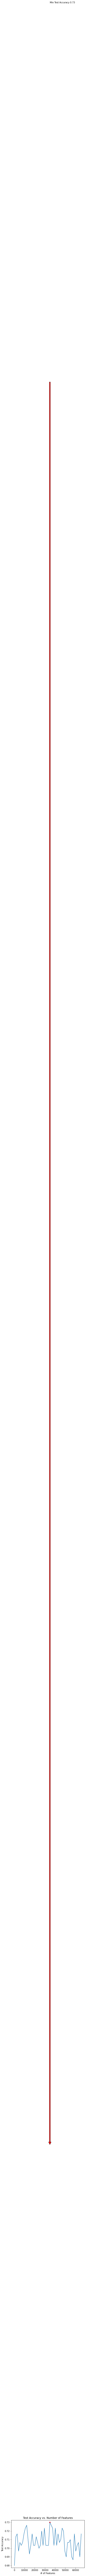

Min Test Accuracy of 0.73 acheived with 34867 features


In [109]:
# Plot Accuracy for various # of features
sns.lineplot(x=k_list, y=test_accuracys)
maxima = []
for i in list(zip(k_list, test_accuracys)):
    if i[1] == max(test_accuracys):
        maxima.append(i)
        for annotation_pt in maxima:
            plt.scatter(annotation_pt[0], annotation_pt[1], marker='o', c="red", s=25)
            annotation_text_position = [annotation_pt[0], annotation_pt[1] * 5]
            plt.annotate(f"Max Test Accuracy {annotation_pt[1]:,.2f}", annotation_pt, xytext=annotation_text_position, arrowprops={'facecolor':'red', "shrink":0.15})
plt.title(f"Test Accuracy vs. Number of Features")
plt.xlabel("# of Features")
plt.ylabel("Test Accuracy")
plt.show()
for annotation_pt in maxima:
    print(f"Max Test Accuracy of {annotation_pt[1]:,.2f} acheived with {annotation_pt[0]} features")